# Кластеризация стран

Произведем кластеризацию стран по имеющимся у них признакам.\
При этом учтем признаки, связанные с причинами детской смертности, которые представлены только до 2017 г.\
Наличие кластера помогает более наглядно представить результаты исследования.\
Поэтому добавление этого признака вынесено в раздел исследования данных.

Для предсказания целевой переменной данные о причинах детской смертности использоваться не будут\
(так как они представлены только до 2017 г.)\
И далее мы сформируем новый признак кластера без них.\
Сейчас же наличие кластера поможет более наглядно показать распределение данных.

In [1]:
import sys
# Добавим папку проекта в список системных директорий, чтобы Python видел путь к папке utils
sys.path.append('..')

In [2]:
from enum import Enum
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from scipy.stats import shapiro

import plotly.express as px

from utils.constants import (
    F, 
    RANDOM_STATE,
    ClusteringAlgorithm,
)
from utils.graphics import (
    display_corellation_by_target,
    display_inertia,
    display_silhouette,
    dislay_correlation_matrix,
    display_clusters_profiles,
    show_and_save_fig,
)
from utils.display_content import (
    dislay_some_fields_description,
)
from utils.prepare_data import (
    move_column_to_end_table,
    get_temp_rename_dict,
    add_child_mortality_data,
    move_column_to_end_table,
)

# Имена полей с номером кластера для разных алгоритмов
class FCluster(Enum):
    K_MEANS = 'ClusterKMeans'
    K_MEANS_PCA = 'ClusterKMeansPCA'
    EM = 'ClusterEM'
    AC = 'ClusterAC'

from warnings import simplefilter
simplefilter('ignore')

In [3]:
# Загрузим таблицу
data_source = pd.read_csv('../data/cumulative_life_expectancy_prepared.csv')

# Удалим столбец с кластером на тот случай, если код файла будет запущен после его добавления
if (F.ClusterKMeans.value in list(data_source.columns)):
    data = data_source.drop(columns=[F.ClusterKMeans.value])
else:
    data = data_source

data.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,BmiTeenagerOverweight2,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,0.99,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,1.07,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,1.14,30.42,43.38,4.19,1.31,11.54,882.147847,17327699.0,5.157312,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,1.22,31.86,44.36,4.26,1.47,14.55,992.698979,17943712.0,5.222375,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,1.31,33.29,45.35,5.66,1.69,21.36,1266.210864,18600423.0,5.287437,52.36


Добавим в таблицу данные о детской смертности.\
Поскольку данные эти есть только до 2017 года, после добавления в таблице остануться данные за 2000-2017 гг.

In [4]:
# Добавим данные о детской смертности
cumulative_data = add_child_mortality_data(data)

# Переставим столбец с таргетом в конец таблицы
cumulative_data = move_column_to_end_table(cumulative_data, F.LifeExpectancy.value)

cumulative_data.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,ChildUnder5Mortality12,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,0.029,0.20,0.095,0.091,0.036,0.21,0.027,0.038,0.087,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,0.030,0.19,0.093,0.090,0.035,0.20,0.027,0.037,0.087,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,0.032,0.18,0.093,0.092,0.037,0.21,0.028,0.037,0.087,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,0.034,0.18,0.099,0.097,0.039,0.21,0.029,0.039,0.091,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,0.036,0.18,0.100,0.100,0.041,0.22,0.030,0.040,0.094,52.36


In [5]:
# Выведем описание полей
dislay_some_fields_description(list(cumulative_data.columns))

**Описание полей:**

- `ParentLocationCode` - Код региона

- `ParentLocation` - Название региона

- `SpatialDimValueCode` - Код страны

- `Location` - Название страны

- `Period` - Год

- `AdultMortality` - Смертность среди взрослого населения от 15 до 60 лет (в % от численности населения)

- `Homicides` - Оценка уровня убийств (%)

- `MaternalMortality` - Коэффициент материнской смертности (%)

- `AdultNcdMortality` - Вероятность (в %) смерти в возрасте от 30 до 70 лет от сердечно-сосудистых заболеваний, рака, диабета или хронических респираторных заболеваний

- `AdultNcdMortality117` - Смертность взрослых от неинфекционных заболеваний (%). Респираторные заболевания

- `AdultNcdMortality110` - Смертность взрослых от неинфекционных заболеваний (%). Сердечно-сосудистые заболевания

- `AdultNcdMortality080` - Смертность взрослых от неинфекционных заболеваний (%). Сахарный диабет

- `AdultNcdMortality061` - Смертность взрослых от неинфекционных заболеваний (%). Злокачественные новообразования

- `AdultNcdMortalitySum` - Сумма причин (в %) смертности взрослых от неинфекционных заболеваний.

- `PoisoningMortality` - Уровень смертности от непреднамеренного отравления (%)

- `SuicideMortality` - Стандартизированные по возрасту показатели самоубийств (%)

- `AlcoholСonsumption` - Потребление алкоголя на душу населения (15+) (в литрах чистого алкоголя)

- `HepatitisBImmunization` - Охват иммунизацией детей в возрасте 1 года против гепатита В (ГепВ3) (%)

- `MeaslesImmunization` - Охват первой дозой вакцины, содержащей коревой компонент (MCV1), среди детей в возрасте 1 года (%)

- `PolioImmunization` - Охват иммунизацией от полиомиелита (Pol3) среди детей в возрасте 1 года (%)

- `DiphtheriaImmunization` - Охват иммунизацией детей в возрасте 1 года дифтерийно-столбнячным анатоксином и коклюшем (АКДС3) (%)

- `BmiAdultUnderweight` - Распространенность недостаточного веса среди взрослых, ИМТ < 18,5 (стандартизированная по возрасту оценка) (%)

- `BmiAdultOverweight25` - Распространенность избыточного веса среди взрослых, ИМТ >= 25 (стандартизированная по возрасту оценка) (%)

- `BmiAdultOverweight30` - Распространенность ожирения среди взрослых, ИМТ >= 30 (стандартизированная по возрасту оценка) (%)

- `BmiChildThinness` - Распространенность худобы среди детей 5-9 лет, ИМТ < -2 стандартных отклонений ниже медианы (грубая оценка) (%)

- `BmiTeenagerThinness` - Распространенность худобы среди подростков 10-19 лет, ИМТ < -2 стандартных отклонений ниже медианы (грубая оценка) (%)

- `BmiChildOverweight1` - Распространенность избыточного веса среди детей 5-9 лет, ИМТ > +1 стандартного отклонения выше медианы (грубая оценка) (%)

- `BmiTeenagerOverweight1` - Распространенность избыточного веса среди подростков 10-19 лет, ИМТ > +1 стандартного отклонения выше медианы (грубая оценка) (%)

- `BmiChildOverweight2` - Распространенность ожирения среди детей 5-9 лет, ИМТ > +2 стандартных отклонений выше медианы (грубая оценка) (%)

- `BmiTeenagerOverweight2` - Распространенность ожирения среди подростков 10-19 лет, ИМТ > +2 стандартных отклонений выше медианы (грубая оценка) (%)

- `Sanitation` - Население, пользующееся как минимум базовыми услугами санитарии (%)

- `DrinkingWater` - Население, пользующееся по крайней мере базовыми услугами питьевого водоснабжения (%)

- `HealthCareCosts` - Общие внутренние государственные расходы на здравоохранение в процентах от общих государственных расходов (%)

- `HealthCareCostsGdp` - Общие внутренние государственные расходы на здравоохранение в процентах от валового внутреннего продукта (ВВП) (%)

- `HealthCareCostsPerCapita` - Общие внутренние государственные расходы на здравоохранение на душу населения в долларах США

- `GdpPerCapita` - ВВП на душу населения (в долл. США)

- `Population` - Общая численность населения

- `Schooling` - Средняя продолжительность формального образования для лиц в возрасте 15–64 лет

- `ChildUnder5Mortality2` - Распределение причин смерти среди детей в возрасте до 5 лет (%). ВИЧ/СПИД.

- `ChildUnder5Mortality5` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Столбняк.

- `ChildUnder5Mortality6` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Корь.

- `ChildUnder5Mortality7` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Менингит/энцефалит.

- `ChildUnder5Mortality8` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Малярия.

- `ChildUnder5Mortality12` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Сепсис и другие инфекционные состояния новорожденных.

- `ChildUnder5Mortality3` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Диарейные заболевания.

- `ChildUnder5Mortality11` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Родовая асфиксия и родовая травма.

- `ChildUnder5Mortality13` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Другие инфекционные, перинатальные и алиментарные состояния.

- `ChildUnder5Mortality17` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Травмы.

- `ChildUnder5Mortality9` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Острые инфекции нижних дыхательных путей.

- `ChildUnder5Mortality16` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Другие неинфекционные заболевания.

- `ChildUnder5Mortality15` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Врожденные аномалии.

- `ChildUnder5Mortality10` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Недоношенность.

- `LifeExpectancy` - Ожидаемая продоложительность жизни

## Корреляция признаков с целевой переменной

Построим график корреляции всех признаков с целевой переменной.

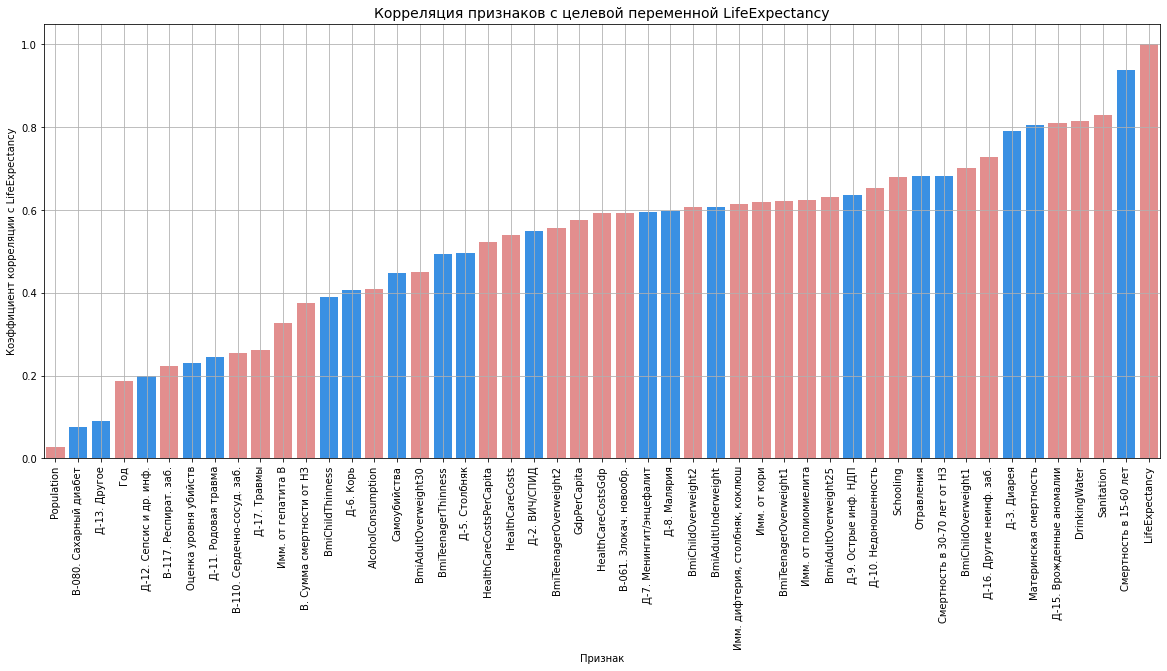

In [6]:
# Для удобства чтения графика сделаем переименование признаков с кодами в названиях
rename_dict = get_temp_rename_dict(cumulative_data)

# Построим график
display_corellation_by_target(
    cumulative_data.rename(columns=rename_dict), 
    figsize=(20, 8)
)

Признаки, имеющие **отрицательную корреляцию с целевой переменной**,\
можно отнести к **факторам неблагополучия стран**. \
То есть, они не способствуют увеличению продолжительности жизни.\
Эти факторы коррелируют также между собой.

Признаки, имеющие **положительную корреляцию с целевой переменной**,\
можно разделить на 2 вида.
- Одни признаки являются **факторами явного благополучия** \
(например, уровень санитарии, доступ к питьевой воде, ВВП на душу населения и др.)
- Другие признаки являются скорее **проблемами развитых стран**. \
Например, врожденные аномалии, недоношенность, злокачественные новообразования и др.\
Они могут проявляться с одной стороны от плохой экологии. \
И с другой стороны эти проблемы проявляются, если смертность благодаря медицине \
не наступает раньше, как в неблагополучных странах.

Признаки из этой группы также коррелируют между собой.

Посмотрим, как по этим признакам разделятся страны с помощью кластеризации.

## Кластеризация с помощью k-means

In [7]:
columns_to_drop = [
    F.Period.value, F.ParentLocationCode.value, 
    F.ParentLocation.value, F.SpatialDimValueCode.value,
]

# Посчитаем средние значения признаков по всем странам
cumulative_mean_data = cumulative_data \
    .drop(columns=columns_to_drop) \
    .groupby(F.Location.value) \
    .agg('mean')
    
cumulative_mean_data.head()

,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,AdultNcdMortality110,AdultNcdMortality080,AdultNcdMortality061,AdultNcdMortalitySum,PoisoningMortality,...,ChildUnder5Mortality12,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy
Location,,,,,,,,,,,,,,,,,,,,,
Afghanistan,32.970556,0.009232,0.982397,39.088889,0.026521,0.204127,0.018473,0.041092,0.290212,0.001766,...,0.071444,0.101222,0.152222,0.076111,0.049889,0.178333,0.049000,0.050333,0.158333,57.991111
Albania,9.098222,0.004934,0.009525,16.522222,0.024715,0.363957,0.006429,0.155068,0.550169,0.000501,...,0.022111,0.014833,0.070556,0.058556,0.097056,0.140333,0.086222,0.243889,0.228889,76.033889
Algeria,9.686222,0.001636,0.119624,15.827778,0.014885,0.189440,0.012545,0.059538,0.276407,0.000891,...,0.081333,0.059278,0.140000,0.050278,0.055333,0.135556,0.076389,0.142222,0.229444,74.729444
Angola,29.310000,0.011315,0.468428,26.222222,0.021080,0.107075,0.017522,0.033227,0.178904,0.003071,...,0.045222,0.147278,0.112222,0.106667,0.049778,0.200000,0.032222,0.049611,0.102611,56.326111
Antigua and Barbuda,11.518333,0.003739,0.034403,17.966667,0.023250,0.213579,0.063271,0.116369,0.416470,0.000600,...,0.018611,0.002944,0.115778,0.081389,0.052944,0.041222,0.189889,0.242222,0.245000,75.344444


Проверим, нормально ли распределены данные.\
Для проверки воспользуемся тестом Шапиро-Уилка.\
Уровень значимости возьмем равным $\alpha=0.05$ 

In [8]:
# Имена столбцов
columns = list(cumulative_mean_data.columns)
# Значения pvalue теста Шапиро-Уилка для признаков
shapiro_pvalues = []

# Уровень значимости
alpha = 0.05 

for column_name in columns:  
    # Вычисляем результат теста Шапиро-Уилка
    shapiro_result = shapiro(cumulative_mean_data[column_name])
    # Сохраняем pvalue
    shapiro_pvalues.append(shapiro_result.pvalue)

# Соберем данные в таблицу
shapiro_data = pd.DataFrame({'feature': columns, 'shapiro_pvalue': shapiro_pvalues})
# Добавим флаг, нормальное ли распределение
shapiro_data['is_normal'] = shapiro_data['shapiro_pvalue'] > alpha

# Посмотрим сколько признаков как распределено
shapiro_data['is_normal'].value_counts()

is_normal
False    47
True      1
Name: count, dtype: int64

Только один признак распределен нормально.\
Поэтому поэтому приведем данные к единому масштабу с помощью `MinMaxScaler`.

In [9]:
# Сохраним названия стран из индекса, которые теряются при преобразовании
locations_index = list(cumulative_mean_data.index)

# Инициализируем нормализатор MinMaxScaler
mm_scaler = MinMaxScaler()

# Кодируем исходный датасет
cumulative_scaled_data = mm_scaler.fit_transform(cumulative_mean_data)

# Добавим имена столбцов и индекс, которые потерялись при преобразовании
cumulative_scaled_data = pd.DataFrame(cumulative_scaled_data, columns=columns, index=locations_index)

# Посмотрим на характеристики распределения
cumulative_scaled_data.describe()

,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,AdultNcdMortality110,AdultNcdMortality080,AdultNcdMortality061,AdultNcdMortalitySum,PoisoningMortality,...,ChildUnder5Mortality12,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,...,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,0.230048,0.125176,0.152080,0.372312,0.361619,0.204713,0.143448,0.306293,0.265582,0.203418,...,0.415847,0.356511,0.222758,0.239241,0.334780,0.371260,0.224461,0.368228,0.301074,0.635860
std,0.191322,0.165714,0.211266,0.216735,0.229569,0.210816,0.149564,0.267695,0.223215,0.211052,...,0.212146,0.299131,0.114970,0.112688,0.162110,0.208899,0.164313,0.266947,0.187703,0.237739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082869,0.026530,0.009002,0.214690,0.188807,0.070358,0.060502,0.090947,0.101006,0.048224,...,0.252336,0.058582,0.148101,0.165051,0.225721,0.176842,0.078424,0.083574,0.148942,0.470947
50%,0.180571,0.074204,0.044617,0.371586,0.322161,0.138958,0.096529,0.181081,0.188624,0.103426,...,0.406267,0.342910,0.220615,0.244646,0.311836,0.410466,0.195480,0.374914,0.301941,0.712074
75%,0.328147,0.153163,0.254926,0.497335,0.472823,0.246064,0.174395,0.523296,0.369665,0.338231,...,0.556350,0.612313,0.298373,0.290707,0.405539,0.528670,0.338613,0.575933,0.407418,0.805180
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Минимальное значение теперь у всех признаков в нуле, максимальное в единице.\
Попробуем определить оптимальное количество кластеров с помощью метода локтя.

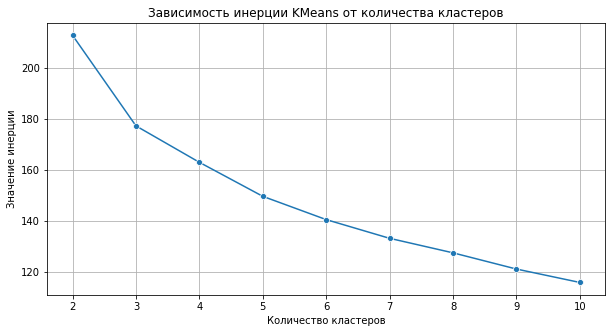

,inertia,clusters_count
0,212.900525,2
1,177.339734,3
2,163.031935,4
3,149.674820,5
4,140.530885,6
5,133.180522,7
6,127.478120,8
7,121.109726,9
8,115.848947,10


In [10]:
# Построим график зависимости значения инерции от количества кластеров
display_inertia(cumulative_scaled_data, 2, 10)

Похоже, что оптимальное количество кластеров равно 3-м.\
Так как начиная с этой точки инерция уменьшается менее интенсивно.

Попробуем подобрать оптимальное количество кластеров с помощью коэффициента силуэта.

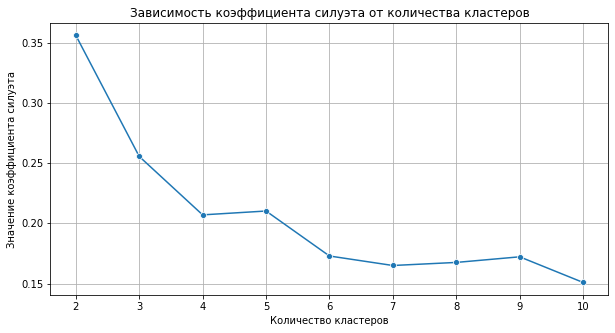

,silhouette,clusters_count
0,0.356054,2
1,0.255518,3
3,0.210186,5
2,0.206993,4
4,0.172841,6
7,0.172163,9
6,0.167504,8
5,0.164952,7
8,0.150877,10


In [11]:
display_silhouette(cumulative_scaled_data, 2, 10)

In [12]:
# Константа с оптимальным количеством кластеров
K_MEANS_CLUSTERS_COUNT = 2

In [13]:
print(f'Наибольшее значение метрики получаем для {K_MEANS_CLUSTERS_COUNT}-х кластеров.')
print(f'Поэтому разделим страны на {K_MEANS_CLUSTERS_COUNT} кластера.')

Наибольшее значение метрики получаем для 2-х кластеров.
Поэтому разделим страны на 2 кластера.


In [14]:
# Создадим объект модели
k_means_model = KMeans(n_clusters=K_MEANS_CLUSTERS_COUNT, random_state=RANDOM_STATE)
# Обучим модель
k_means_model.fit_predict(cumulative_scaled_data)
# Создадим столбец с метками кластеров
cumulative_scaled_data[FCluster.K_MEANS.value] = k_means_model.labels_

cumulative_scaled_data.head()

,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,AdultNcdMortality110,AdultNcdMortality080,AdultNcdMortality061,AdultNcdMortalitySum,PoisoningMortality,...,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy,ClusterKMeans
Afghanistan,0.460669,0.125335,0.790629,0.897069,0.266824,0.154748,0.074657,0.075262,0.151883,0.251004,...,0.679851,0.394213,0.218182,0.236722,0.582483,0.107978,0.056313,0.195885,0.311479,1
Albania,0.063786,0.064135,0.004763,0.220520,0.246645,0.326583,0.003352,0.441515,0.365338,0.067698,...,0.099627,0.128391,0.154343,0.558801,0.455558,0.237396,0.536004,0.379890,0.809799,0
Algeria,0.073562,0.017173,0.093699,0.199700,0.136751,0.138958,0.039564,0.134536,0.140548,0.124267,...,0.398134,0.354430,0.124242,0.273900,0.439599,0.203206,0.284042,0.381339,0.773771,0
Angola,0.399811,0.154990,0.375455,0.511326,0.206003,0.050407,0.069031,0.049990,0.060486,0.439943,...,0.989179,0.264014,0.329293,0.235964,0.654852,0.049643,0.054523,0.050565,0.265493,1
Antigua and Barbuda,0.104021,0.047128,0.024859,0.263824,0.230266,0.164910,0.339895,0.317160,0.255555,0.082134,...,0.019776,0.275588,0.237374,0.257587,0.124513,0.597837,0.531874,0.421907,0.790757,0


Отобразим на карте полученные кластеры.

In [15]:
# Загрузим таблицу с кодами стран
regions_and_locations_data = pd.read_csv(
    '../data/regions_and_locations.csv'
)
regions_and_locations_data.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location
0,AFR,Africa,AGO,Angola
1,AFR,Africa,BDI,Burundi
2,AFR,Africa,BEN,Benin
3,AFR,Africa,BFA,Burkina Faso
4,AFR,Africa,BWA,Botswana


In [16]:
# Создадим таблицу для отображения кластеров стран на карте
location_clusters_data = cumulative_scaled_data[[FCluster.K_MEANS.value]] \
    .reset_index() \
    .rename(columns={'index': F.Location.value})
    
location_clusters_data = location_clusters_data.merge(
    regions_and_locations_data,
    on=[F.Location.value],
    how='left',
)
location_clusters_data = move_column_to_end_table(location_clusters_data, FCluster.K_MEANS.value)

location_clusters_data.head()

,Location,ParentLocationCode,ParentLocation,SpatialDimValueCode,ClusterKMeans
0,Afghanistan,EMR,Eastern Mediterranean,AFG,1
1,Albania,EUR,Europe,ALB,0
2,Algeria,AFR,Africa,DZA,0
3,Angola,AFR,Africa,AGO,1
4,Antigua and Barbuda,AMR,Americas,ATG,0


In [17]:
# Удалим из основной таблицы столбец с кластерами
cumulative_scaled_data.drop(columns=[FCluster.K_MEANS.value], inplace=True)

In [18]:
# Отобразим график с кластерами стран
fig = px.choropleth(
    location_clusters_data, 
    locations=F.SpatialDimValueCode.value, 
    color=FCluster.K_MEANS.value,
    hover_name=F.Location.value,
    projection='natural earth',
    width=1000,
    height=700,
    title=f'Разделение стран на {K_MEANS_CLUSTERS_COUNT} кластера с помощью k-means',
)

show_and_save_fig(fig, 'locations_clusters_kmeans_1')

На графике видно, что страны с одинаковыми кластерами находятся территориально близко друг к другу.\
По данным предыдущих исследований можно предположить, \
что к кластеру 1 отнесены страны с неблагополучными условиями жизни,\
а к кластеру 0 с более благополучными.

## Кластеризация с помощью EM-алгоритма

С помощью метрики силуэта определим, на какое количество кластеров лучше разделить данные.

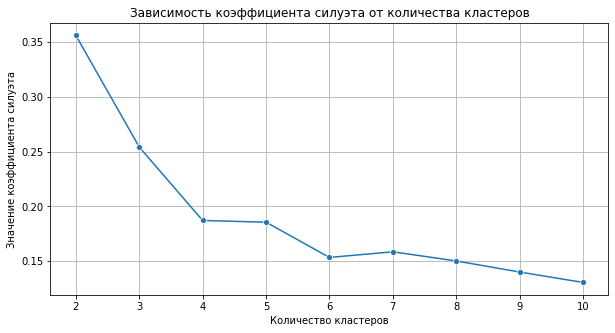

,silhouette,clusters_count
0,0.356054,2
1,0.254229,3
2,0.187222,4
3,0.185644,5
5,0.158650,7
4,0.153509,6
6,0.150297,8
7,0.140200,9
8,0.130701,10


In [19]:
# Построим график зависимости значения коэффициента силуэта от количества кластеров
display_silhouette(
    cumulative_scaled_data, 
    2, 
    10, 
    ClusteringAlgorithm.EM.value,
)

In [20]:
# Оптимальное количество кластеров
EM_CLUSTERS_COUNT = 2

In [21]:
print(f'Наибольшее значение метрика силуэта принимает для {EM_CLUSTERS_COUNT}-х кластеров.')
print(f'Разделим страны на {EM_CLUSTERS_COUNT} кластера.')

Наибольшее значение метрика силуэта принимает для 2-х кластеров.
Разделим страны на 2 кластера.


In [22]:
gm_model = GaussianMixture(n_components=EM_CLUSTERS_COUNT, random_state=RANDOM_STATE)

gm_clusters = gm_model.fit_predict(cumulative_scaled_data)

cumulative_scaled_data[FCluster.EM.value] = gm_clusters

cumulative_scaled_data.head()

,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,AdultNcdMortality110,AdultNcdMortality080,AdultNcdMortality061,AdultNcdMortalitySum,PoisoningMortality,...,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy,ClusterEM
Afghanistan,0.460669,0.125335,0.790629,0.897069,0.266824,0.154748,0.074657,0.075262,0.151883,0.251004,...,0.679851,0.394213,0.218182,0.236722,0.582483,0.107978,0.056313,0.195885,0.311479,1
Albania,0.063786,0.064135,0.004763,0.220520,0.246645,0.326583,0.003352,0.441515,0.365338,0.067698,...,0.099627,0.128391,0.154343,0.558801,0.455558,0.237396,0.536004,0.379890,0.809799,0
Algeria,0.073562,0.017173,0.093699,0.199700,0.136751,0.138958,0.039564,0.134536,0.140548,0.124267,...,0.398134,0.354430,0.124242,0.273900,0.439599,0.203206,0.284042,0.381339,0.773771,0
Angola,0.399811,0.154990,0.375455,0.511326,0.206003,0.050407,0.069031,0.049990,0.060486,0.439943,...,0.989179,0.264014,0.329293,0.235964,0.654852,0.049643,0.054523,0.050565,0.265493,1
Antigua and Barbuda,0.104021,0.047128,0.024859,0.263824,0.230266,0.164910,0.339895,0.317160,0.255555,0.082134,...,0.019776,0.275588,0.237374,0.257587,0.124513,0.597837,0.531874,0.421907,0.790757,0


Также отобразим полученные кластеры на карте.

In [23]:
# Добавим столбец с кластерами, определенными EM алгоритмом в таблицу location_clusters_data
location_clusters_em_data = cumulative_scaled_data[[FCluster.EM.value]] \
    .reset_index() \
    .rename(columns={'index': F.Location.value})
    
location_clusters_data = location_clusters_data.merge(
    location_clusters_em_data,
    on=[F.Location.value],
    how='left',
)

location_clusters_data.head()

,Location,ParentLocationCode,ParentLocation,SpatialDimValueCode,ClusterKMeans,ClusterEM
0,Afghanistan,EMR,Eastern Mediterranean,AFG,1,1
1,Albania,EUR,Europe,ALB,0,0
2,Algeria,AFR,Africa,DZA,0,0
3,Angola,AFR,Africa,AGO,1,1
4,Antigua and Barbuda,AMR,Americas,ATG,0,0


In [24]:
# Удалим из основной таблицы столбец с кластерами
cumulative_scaled_data.drop(columns=[FCluster.EM.value], inplace=True)

In [25]:
# Отобразим график с кластерами стран
fig = px.choropleth(
    location_clusters_data, 
    locations=F.SpatialDimValueCode.value, 
    color=FCluster.EM.value,
    hover_name=F.Location.value,
    projection='natural earth',
    width=1000,
    height=700,
    title=f'Разделение стран на {EM_CLUSTERS_COUNT} кластера с помощью EM-алгоритма',
)

show_and_save_fig(fig, 'locations_clusters_em')

Судя по карте, разделение очень похоже на предыдущее.\
Посмотрим, в каких странах есть различия по определенными кластерам.

In [26]:
location_clusters_data['VariousClusters'] = location_clusters_data \
    .apply(lambda row: 0 if row[FCluster.K_MEANS.value] == row[FCluster.EM.value] else 1, axis=1)

mask = location_clusters_data['VariousClusters'] == 1

location_clusters_data[mask]

,Location,ParentLocationCode,ParentLocation,SpatialDimValueCode,ClusterKMeans,ClusterEM,VariousClusters


In [27]:
if (location_clusters_data[mask].shape[0] == 0):
    print(f'Два алгоритма одинаково разделили страны на {EM_CLUSTERS_COUNT} кластера.')

Два алгоритма одинаково разделили страны на 2 кластера.


In [28]:
# Удалим столбец VariousClusters
location_clusters_data.drop(columns=['VariousClusters'], inplace=True)

## Агломеративная иерархическая кластеризация

С помощью метрики силуэта определим, на какое количество кластеров лучше разделить данные.

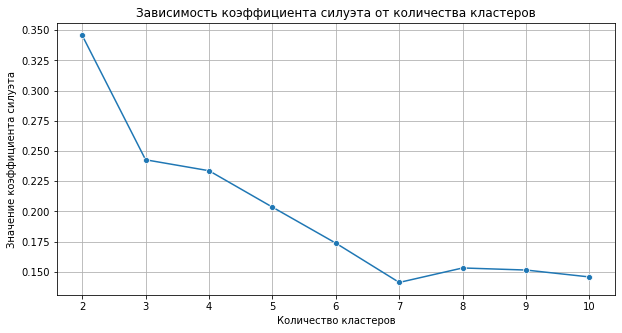

,silhouette,clusters_count
0,0.345642,2
1,0.242695,3
2,0.233644,4
3,0.203521,5
4,0.173712,6
6,0.153188,8
7,0.151466,9
8,0.145755,10
5,0.141206,7


In [29]:
# Построим график зависимости значения коэффициента силуэта от количества кластеров
display_silhouette(
    cumulative_scaled_data, 
    2, 
    10, 
    ClusteringAlgorithm.AC.value,
)

In [30]:
# Оптимальное количество кластеров
AC_CLUSTERS_COUNT = 2

In [31]:
print(f'Наибольшее значение метрика силуэта принимает для {AC_CLUSTERS_COUNT}-х кластеров.')
print(f'Разделим страны на {AC_CLUSTERS_COUNT} кластера.')

Наибольшее значение метрика силуэта принимает для 2-х кластеров.
Разделим страны на 2 кластера.


In [32]:
ac_model = AgglomerativeClustering(n_clusters=AC_CLUSTERS_COUNT)

ac_model.fit(cumulative_scaled_data)

cumulative_scaled_data[FCluster.AC.value] = ac_model.labels_

cumulative_scaled_data.head()

,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,AdultNcdMortality110,AdultNcdMortality080,AdultNcdMortality061,AdultNcdMortalitySum,PoisoningMortality,...,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy,ClusterAC
Afghanistan,0.460669,0.125335,0.790629,0.897069,0.266824,0.154748,0.074657,0.075262,0.151883,0.251004,...,0.679851,0.394213,0.218182,0.236722,0.582483,0.107978,0.056313,0.195885,0.311479,1
Albania,0.063786,0.064135,0.004763,0.220520,0.246645,0.326583,0.003352,0.441515,0.365338,0.067698,...,0.099627,0.128391,0.154343,0.558801,0.455558,0.237396,0.536004,0.379890,0.809799,0
Algeria,0.073562,0.017173,0.093699,0.199700,0.136751,0.138958,0.039564,0.134536,0.140548,0.124267,...,0.398134,0.354430,0.124242,0.273900,0.439599,0.203206,0.284042,0.381339,0.773771,0
Angola,0.399811,0.154990,0.375455,0.511326,0.206003,0.050407,0.069031,0.049990,0.060486,0.439943,...,0.989179,0.264014,0.329293,0.235964,0.654852,0.049643,0.054523,0.050565,0.265493,1
Antigua and Barbuda,0.104021,0.047128,0.024859,0.263824,0.230266,0.164910,0.339895,0.317160,0.255555,0.082134,...,0.019776,0.275588,0.237374,0.257587,0.124513,0.597837,0.531874,0.421907,0.790757,0


Отобразим полученные кластеры на карте.

In [33]:
# Добавим столбец с кластерами, определенными алгоритмом в таблицу location_clusters_data
location_clusters_ac_data = cumulative_scaled_data[[FCluster.AC.value]] \
    .reset_index() \
    .rename(columns={'index': F.Location.value})
    
location_clusters_data = location_clusters_data.merge(
    location_clusters_ac_data,
    on=[F.Location.value],
    how='left',
)

location_clusters_data.head()

,Location,ParentLocationCode,ParentLocation,SpatialDimValueCode,ClusterKMeans,ClusterEM,ClusterAC
0,Afghanistan,EMR,Eastern Mediterranean,AFG,1,1,1
1,Albania,EUR,Europe,ALB,0,0,0
2,Algeria,AFR,Africa,DZA,0,0,0
3,Angola,AFR,Africa,AGO,1,1,1
4,Antigua and Barbuda,AMR,Americas,ATG,0,0,0


In [34]:
# Удалим из основной таблицы столбец с кластерами
cumulative_scaled_data.drop(columns=[FCluster.AC.value], inplace=True)

In [35]:
# Отобразим график с кластерами стран
fig = px.choropleth(
    location_clusters_data, 
    locations=F.SpatialDimValueCode.value, 
    color=FCluster.AC.value,
    hover_name=F.Location.value,
    projection='natural earth',
    width=1000,
    height=700,
    title=f'Разделение стран на {AC_CLUSTERS_COUNT} кластера с помощью агломеративной иерархической кластеризации',
)

show_and_save_fig(fig, 'locations_clusters_ac')

Судя по карте, разделение очень похоже на разделение с помощью k-means и EM-алгоритма.\
Посмотрим, в каких странах есть различия по определенными кластерам.

In [36]:
location_clusters_data['VariousClusters'] = location_clusters_data \
    .apply(lambda row: 0 if row[FCluster.K_MEANS.value] == row[FCluster.AC.value] else 1, axis=1)

mask = location_clusters_data['VariousClusters'] == 1

location_clusters_data[mask][[F.Location.value, FCluster.K_MEANS.value, FCluster.AC.value]]

,Location,ClusterKMeans,ClusterAC
18,Bhutan,1,0
86,Kiribati,0,1
106,Micronesia (Federated States of),0,1
138,Samoa,0,1
158,Tajikistan,1,0
177,Viet Nam,1,0


In [37]:
print(f'Расхождение только по {location_clusters_data[mask].shape[0]} странам.')

Расхождение только по 6 странам.


In [38]:
# Удалим столбец VariousClusters
location_clusters_data.drop(columns=['VariousClusters'], inplace=True)

## Снижение размерности данных с помощью PCA

Снизим размерность данных с помощью алгоритма\
**PCA (Principal Component Analysis, метод главных компонент)**\
А затем кластеризуем полученные данные с помощью k-means и посмотрим на результат.

Найдем минимальное число компонент, которые смогут объяснить как минимум 90% данных.

In [39]:
# Создаем объект класса PCA
pca = PCA(n_components=0.9)

# Обучаем на наших масштабированных данных и получаем данные главных компонент
principal_components = pca.fit_transform(cumulative_scaled_data)

# Количество полученных компонент
components_count = principal_components.shape[1]
print(f'Количество полученных компонент: {components_count}')

Количество полученных компонент: 14


Объединим полученные компоненты в таблицу.

In [40]:
# Имена колонок таблицы с компонентами
columns_pc = ['c_' + str(i) for i in range(1, components_count + 1)]

# Таблица с компонентами
principal_components_data = pd.DataFrame(
    principal_components, 
    columns=columns_pc,
    index=locations_index
)
principal_components_data.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14
Afghanistan,1.735500,-0.069228,-0.153722,-0.302940,-0.556906,0.016841,0.127899,0.059145,-0.010883,0.035597,0.050951,-0.427524,0.430419,-0.006857
Albania,-0.607620,0.051466,0.182195,0.210228,-0.090655,-0.428494,0.057893,-0.159558,0.018945,-0.055383,-0.129379,0.182435,0.120801,0.033360
Algeria,-0.105882,0.584212,-0.020569,0.147681,-0.141197,-0.009723,-0.171178,-0.167047,-0.041931,-0.120281,-0.024508,-0.183331,-0.052655,-0.174942
Angola,1.635088,-0.275037,-0.392003,-0.518873,-0.173357,-0.105809,-0.158263,-0.119869,0.279363,0.122421,0.029670,0.172086,0.096874,-0.008702
Antigua and Barbuda,-0.929006,0.407103,-0.051219,-0.167321,0.119160,-0.162593,0.024377,0.315507,-0.264028,0.087895,0.164017,0.057267,0.231613,-0.106137


Посмотрим, какую долю дисперсии объясняет каждая компонента.

In [41]:
pca.explained_variance_ratio_

array([0.50523785, 0.09111594, 0.05975463, 0.0552828 , 0.03804096,
       0.02994721, 0.02520264, 0.02225443, 0.01826752, 0.01520454,
       0.01462695, 0.01188686, 0.00988594, 0.00870754])

Первая компонента объясняет приблизительно 51%.\
Посмотрим на сумму значений, она должна дать примерно 90%.

In [42]:
pca.explained_variance_ratio_.sum()

0.9054158034945109

Так и есть, сумма объясненной дисперсии составляет приблизительно 90%.

При создании компонент с помощью PCA они должны получиться независимыми.\
Посмотрим на коэффициенты корреляции между компонентами.

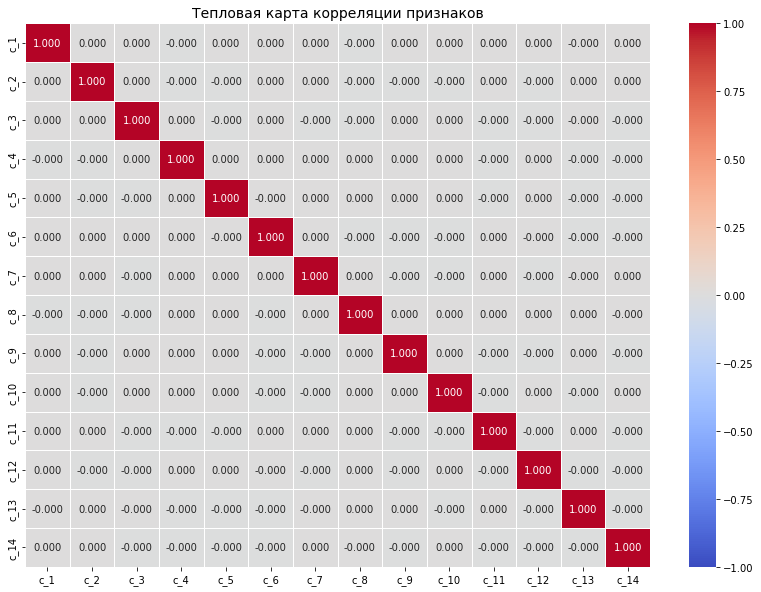

In [43]:
dislay_correlation_matrix(principal_components_data, (14, 10))

Так и есть, компоненты независимы и не имеют корреляции между собой.\
Теперь на полученных признаках компонент реализуем кластеризацию с помощью k-means.

### Кластеризация с помощью k-means на признаках главных компонент

Определим оптимальное количество кластеров.\
Сначала посмотрим на значение инерции.

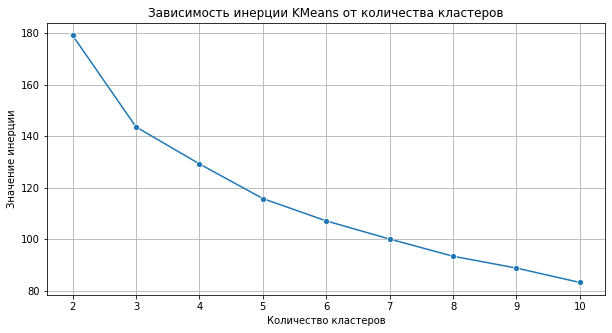

,inertia,clusters_count
0,179.074287,2
1,143.577070,3
2,129.224430,4
3,115.778794,5
4,107.113807,6
5,100.067465,7
6,93.409291,8
7,88.809113,9
8,83.235375,10


In [44]:
# Построим график зависимости значения инерции от количества кластеров
display_inertia(principal_components_data, 2, 10)

На первый взгляд кажется, что можно взять 3 кластера, так как, начиная с этого значения,\
инерция уменьшается медленнее.

Посмотрим на изменение метрики силуэта.

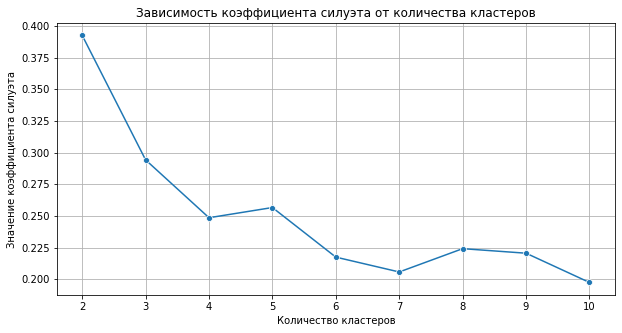

,silhouette,clusters_count
0,0.392484,2
1,0.294214,3
3,0.256603,5
2,0.248552,4
6,0.224142,8
7,0.220559,9
4,0.217468,6
5,0.205748,7
8,0.197485,10


In [45]:
display_silhouette(principal_components_data, 2, 10)

In [46]:
# Константа с оптимальным количеством кластеров
K_MEANS_PCA_CLUSTERS_COUNT = 2

In [47]:
print(f'Наибольшее значение метрики получаем для {K_MEANS_PCA_CLUSTERS_COUNT}-х кластеров.')
print(f'Поэтому разделим данные на {K_MEANS_PCA_CLUSTERS_COUNT} кластера.')

Наибольшее значение метрики получаем для 2-х кластеров.
Поэтому разделим данные на 2 кластера.


In [48]:
# Создадим объект модели
k_means_model = KMeans(n_clusters=K_MEANS_PCA_CLUSTERS_COUNT, random_state=RANDOM_STATE)
# Обучим модель
k_means_model.fit_predict(principal_components_data)
# Создадим столбец с метками кластеров
principal_components_data[FCluster.K_MEANS_PCA.value] = k_means_model.labels_

principal_components_data.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,ClusterKMeansPCA
Afghanistan,1.735500,-0.069228,-0.153722,-0.302940,-0.556906,0.016841,0.127899,0.059145,-0.010883,0.035597,0.050951,-0.427524,0.430419,-0.006857,1
Albania,-0.607620,0.051466,0.182195,0.210228,-0.090655,-0.428494,0.057893,-0.159558,0.018945,-0.055383,-0.129379,0.182435,0.120801,0.033360,0
Algeria,-0.105882,0.584212,-0.020569,0.147681,-0.141197,-0.009723,-0.171178,-0.167047,-0.041931,-0.120281,-0.024508,-0.183331,-0.052655,-0.174942,0
Angola,1.635088,-0.275037,-0.392003,-0.518873,-0.173357,-0.105809,-0.158263,-0.119869,0.279363,0.122421,0.029670,0.172086,0.096874,-0.008702,1
Antigua and Barbuda,-0.929006,0.407103,-0.051219,-0.167321,0.119160,-0.162593,0.024377,0.315507,-0.264028,0.087895,0.164017,0.057267,0.231613,-0.106137,0


Отобразим полученные кластеры на карте.

In [49]:
# Добавим столбец с кластерами в таблицу location_clusters_data
location_clusters_pca_data = principal_components_data[[FCluster.K_MEANS_PCA.value]] \
    .reset_index() \
    .rename(columns={'index': F.Location.value})
    
location_clusters_data = location_clusters_data.merge(
    location_clusters_pca_data,
    on=[F.Location.value],
    how='left',
)

location_clusters_data.head()

,Location,ParentLocationCode,ParentLocation,SpatialDimValueCode,ClusterKMeans,ClusterEM,ClusterAC,ClusterKMeansPCA
0,Afghanistan,EMR,Eastern Mediterranean,AFG,1,1,1,1
1,Albania,EUR,Europe,ALB,0,0,0,0
2,Algeria,AFR,Africa,DZA,0,0,0,0
3,Angola,AFR,Africa,AGO,1,1,1,1
4,Antigua and Barbuda,AMR,Americas,ATG,0,0,0,0


In [50]:
# Удалим из таблицы с компонентами столбец с кластерами
principal_components_data.drop(columns=[FCluster.K_MEANS_PCA.value], inplace=True)

In [51]:
# Отобразим график с кластерами стран
fig = px.choropleth(
    location_clusters_data, 
    locations=F.SpatialDimValueCode.value, 
    color=FCluster.K_MEANS_PCA.value,
    hover_name=F.Location.value,
    projection='natural earth',
    width=1000,
    height=700,
    title=f'Разделение стран на {K_MEANS_PCA_CLUSTERS_COUNT} кластера с помощью k-means на главных компонентах',
)

show_and_save_fig(fig, 'locations_clusters_kmeans_pca')

График очень похож на предыдущий результат кластеризации с помощью k-means.\
Посмотрим, есть ли различия в определении кластеров.

In [52]:
location_clusters_data['VariousClusters'] = location_clusters_data \
    .apply(lambda row: 0 if row[FCluster.K_MEANS.value] == row[FCluster.K_MEANS_PCA.value] else 1, axis=1)

mask = location_clusters_data['VariousClusters'] == 1

location_clusters_data[mask]

,Location,ParentLocationCode,ParentLocation,SpatialDimValueCode,ClusterKMeans,ClusterEM,ClusterAC,ClusterKMeansPCA,VariousClusters


In [53]:
if (location_clusters_data[mask].shape[0] == 0):
    print(f'Оба способа одинаково разделили страны на {K_MEANS_PCA_CLUSTERS_COUNT} кластера.')

Оба способа одинаково разделили страны на 2 кластера.


In [54]:
# Удалим столбец VariousClusters
location_clusters_data.drop(columns=['VariousClusters'], inplace=True)

## Диаграмма рассеяния для результата кластеризации с помощью k-means

Пока лучшее значение метрики мы получили для результата кластеризации с помощью k-means.\
Построим диаграмму рассеяния полученных классов по двум признакам:
- ожидаемая продолжительность жизни
- процент людей, имеющих возможность пользоваться базовыми услугами санитарии

In [55]:
# Создадим таблицу для построения графика
kmeans_clusters_data = cumulative_mean_data[[
    F.Sanitation.value, F.LifeExpectancy.value
]].reset_index().rename(columns={ 'index': F.Location.value })

kmeans_clusters_data = kmeans_clusters_data.merge(
    location_clusters_data[[F.Location.value, FCluster.K_MEANS.value]],
    on=[F.Location.value],
    how='left',
)

# Переведем признак с кластером в строковый для более удобного отображения на графике
kmeans_clusters_data[FCluster.K_MEANS.value] = kmeans_clusters_data[FCluster.K_MEANS.value].astype(str)

kmeans_clusters_data.head()

,Location,Sanitation,LifeExpectancy,ClusterKMeans
0,Afghanistan,33.236667,57.991111,1
1,Albania,94.208889,76.033889,0
2,Algeria,86.195556,74.729444,0
3,Angola,39.013333,56.326111,1
4,Antigua and Barbuda,88.130049,75.344444,0


In [56]:
# Отобразим данные на графике
fig = px.scatter(
    kmeans_clusters_data,
    x=F.LifeExpectancy.value, 
    y=F.Sanitation.value,
    hover_name=F.Location.value,
    color=FCluster.K_MEANS.value,
)

fig.update_layout(
    title='Распределение стран по кластерам',
    xaxis_title='Ожидаемая продолжительность жизни',
    yaxis_title='Доступ к услугам санитарии (%)',
)

show_and_save_fig(fig, 'locations_clusters_kmeans_2')

По графику видно, что в кластер 0 определились страны с большей продолжительностью жизни и лучшим уровнем санитарии.\
В кластер 1 - страны с соответственно меньшими значениями.\
Есть исключения в обоих классах. \
Например, страна Кибарити, находится среди точек кластера 1, но принадлежит к кластеру 0.\
Вероятно, ее отношение к кластеру 0 определяется другими признаками.

Но разделение на классы прослеживается довольно четкое по расположению точек на плоскости и на карте.

## Диаграмма профилей кластеров

Для полученных двух кластеров найдем среднее по признакам:

In [57]:
dislay_some_fields_description([
    F.LifeExpectancy.value,
    F.Sanitation.value,
    F.MaternalMortality.value,
    F.Schooling.value,
])

**Описание полей:**

- `LifeExpectancy` - Ожидаемая продоложительность жизни

- `Sanitation` - Население, пользующееся как минимум базовыми услугами санитарии (%)

- `MaternalMortality` - Коэффициент материнской смертности (%)

- `Schooling` - Средняя продолжительность формального образования для лиц в возрасте 15–64 лет

А также посчитаем среднее по факторам иммунизации:

In [58]:
dislay_some_fields_description([
    F.MeaslesImmunization.value,
    F.PolioImmunization.value,
    F.DiphtheriaImmunization.value,
])

**Описание полей:**

- `MeaslesImmunization` - Охват первой дозой вакцины, содержащей коревой компонент (MCV1), среди детей в возрасте 1 года (%)

- `PolioImmunization` - Охват иммунизацией от полиомиелита (Pol3) среди детей в возрасте 1 года (%)

- `DiphtheriaImmunization` - Охват иммунизацией детей в возрасте 1 года дифтерийно-столбнячным анатоксином и коклюшем (АКДС3) (%)

In [59]:
# Признаки, которые будем рассматривать для построения диаграмм
columns_profiles = [
    F.LifeExpectancy.value,
    F.Sanitation.value,
    F.MaternalMortality.value,
    F.Schooling.value,
    F.MeaslesImmunization.value,
    F.PolioImmunization.value,
    F.DiphtheriaImmunization.value,
]

# Создадим таблицу с нужными столбцами
profiles_data = cumulative_scaled_data[columns_profiles]
# Переведем названия стран из индекса в столбец
profiles_data = profiles_data.reset_index().rename(columns={'index': F.Location.value})
# Добавим номер кластера
profiles_data = profiles_data.merge(
    location_clusters_data[[F.Location.value, FCluster.K_MEANS.value]],
    on=F.Location.value,
    how='left'
)

profiles_data.head()

,Location,LifeExpectancy,Sanitation,MaternalMortality,Schooling,MeaslesImmunization,PolioImmunization,DiphtheriaImmunization,ClusterKMeans
0,Afghanistan,0.311479,0.294157,0.790629,0.174072,0.260947,0.312102,0.357973,1
1,Albania,0.809799,0.938775,0.004763,0.734675,0.963360,0.987261,0.986711,0
2,Algeria,0.773771,0.854055,0.093699,0.438705,0.843610,0.880801,0.892027,0
3,Angola,0.265493,0.355230,0.375455,0.327758,0.184093,0.000000,0.259136,1
4,Antigua and Barbuda,0.790757,0.874507,0.024859,0.615322,0.966041,0.955414,0.981728,0


In [60]:
# Сгруппируем данные по кластерам и возьмем среднее по всем признакам
profiles_clusters_data = profiles_data \
    .drop(columns=[F.Location.value]) \
    .groupby(FCluster.K_MEANS.value) \
    .agg('mean')

# Возьмем среднее по факторам иммунизации
profiles_clusters_data['Immunization'] = \
    profiles_clusters_data[[
        F.MeaslesImmunization.value,
        F.PolioImmunization.value,
        F.DiphtheriaImmunization.value,
    ]].mean(axis=1)

# Удалим лишние столбцы
profiles_clusters_data.drop(columns=[
    F.MeaslesImmunization.value,
    F.PolioImmunization.value,
    F.DiphtheriaImmunization.value,
], inplace=True)

profiles_clusters_data.head()

,LifeExpectancy,Sanitation,MaternalMortality,Schooling,Immunization
ClusterKMeans,,,,,
0,0.779425,0.889438,0.029524,0.707315,0.905983
1,0.373404,0.309023,0.376128,0.342315,0.604153


In [61]:
# Выведем полярную диаграмму с данными кластеров
display_clusters_profiles(
    profiles_clusters_data, 
    file_name='clusters_profiles_03', 
    should_display_table=False, 
    is_custom_size=False,
)

По диаграмме видно, что в **кластере 0** больше значения признаков:
- Процент населения, имеющий доступ к базовым услугам санитарии
- Ожидаемая продолжительность жизни
- Иммунизация
- Время обучения

И практически в нуле материнская смертность.

В **кластере 1** выше материнская смертность.\
А все остальные показатели, соответственно, ниже.

Таким образом, страны с более благоприятными условиями для жизни попали в кластер 0,\
а с менее благоприятными - в кластер 1.

## Добавление признака кластера в исходную таблицу

Добавим признак кластера в исходную таблицу.

In [62]:
# Если кластер еще не был добавлен в исходную таблицу
if (not F.ClusterKMeans.value in list(data_source.columns)):   
    data_source = data_source.merge(
        location_clusters_data[[F.SpatialDimValueCode.value, FCluster.K_MEANS.value]],
        on=F.SpatialDimValueCode.value,
        how='left',
    )
    data_source = move_column_to_end_table(data_source, F.LifeExpectancy.value)
    
    # Сохраним полученную таблицу для дальнейшего использования
    data_source.to_csv('../data/cumulative_life_expectancy_prepared.csv', index=False)

data_source.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,1,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,1,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,30.42,43.38,4.19,1.31,11.54,882.147847,17327699.0,5.157312,1,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,31.86,44.36,4.26,1.47,14.55,992.698979,17943712.0,5.222375,1,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,33.29,45.35,5.66,1.69,21.36,1266.210864,18600423.0,5.287437,1,52.36


## Корреляция признака кластера с целевой переменной

Посмотрим, какую корреляцию с целевой переменной дает новый признак.

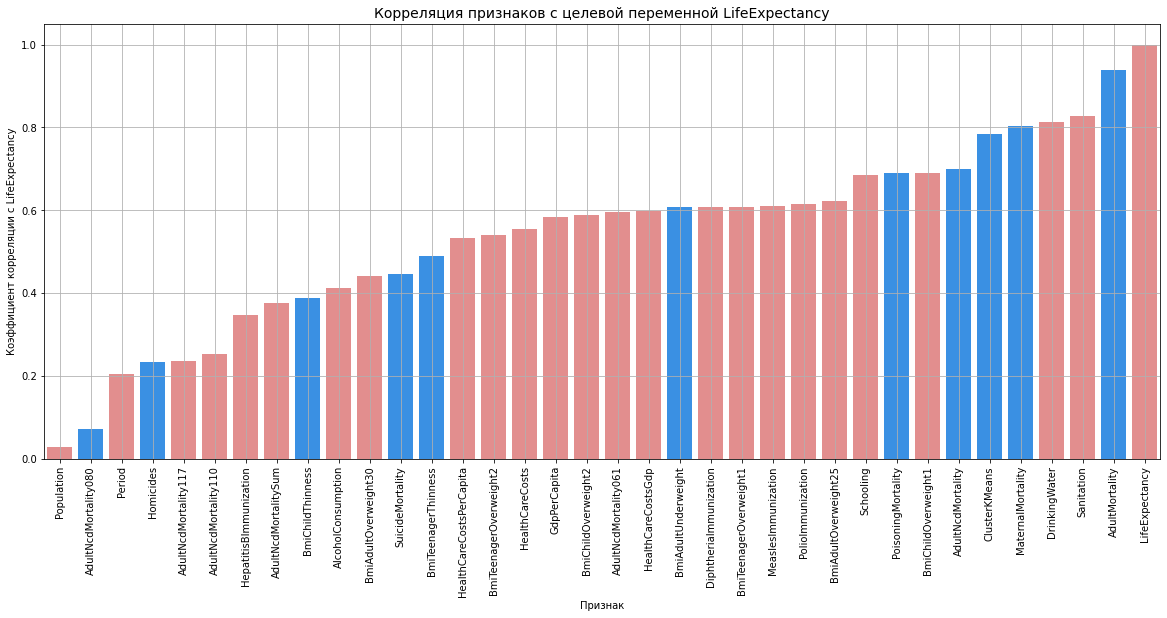

In [63]:
display_corellation_by_target(data_source, figsize=(20, 8))

Признак кластера имеет коэффициент корреляции с целевым близкий к 0.8, что неплохо.

Также признак имеет отрицательную корреляцию с ожидаемой продолжительностью жизни.

Поскольку в кластер 0 попали страны с более благополучными условиями, а в кластер 1 с менее, то получается, \
что чем меньше значение кластера (0), тем больше ожидаемая продолжительность жизни\
а чем больше значение кластера (1), тем меньше ожидаемая продолжительность жизни.

Поэтому корреляция отрицательная.

> Логика создания признака кластера продублирована в классе [LocationCluster](../classes/LocationCluster.py) из папки [classes](../classes/).